[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_1_of_4.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cako/cuda-by-numba-examples/main?filepath=CUDA_by_Numba_Examples_1_of_4.ipynb)

<center>
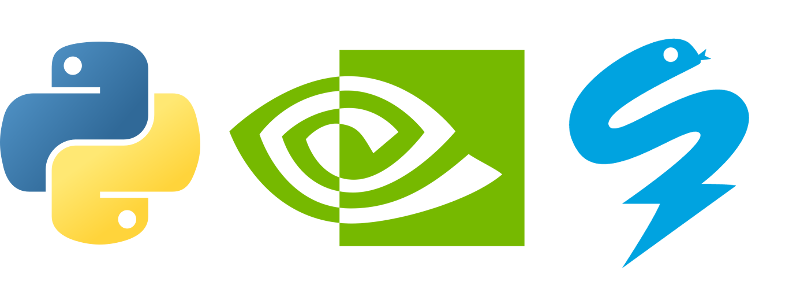
</center>

<h1><center>CUDA by Numba Examples</center></h1>
<h2><center>Part 1 of 4: Embarking on a Parallel Journey</center></h2>
<h3><center>Carlos Costa (<a href="https://github.com/cako">@cako</a>)</center></h3>
<h4><center>July 2022</center></h4>

<hr>

<h3>Introduction</h3>

GPUs (graphics processing units) as the name implies, were originally developed for computer graphics. Since then, they have become ubiquitous in almost every area that requires high computational throughput. This progress has been enabled by the development of GPGPU (general purpose GPU) interfaces, which allow us to program GPUs for general-purpose computing. The most common of these interfaces is <a href="https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html">CUDA</a>, followed by <a href="https://www.khronos.org/opencl/">OpenCL</a> and most recently, <a href="https://rocmdocs.amd.com/en/latest/Programming_Guides/Programming-Guides.html">HIP</a>.

<br>
<center>
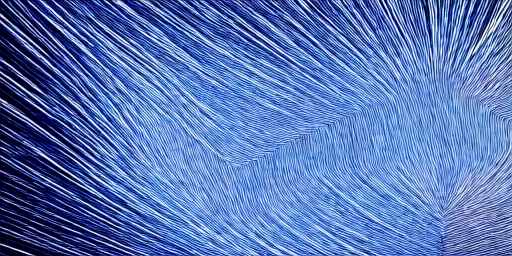
<p>Figure 1.0. Running Stable Diffusion with "parallel lines futuristic space". Credits: Own work under the CreativeML Open RAIL-M license.</p>
</center>


<h3>CUDA in Python</h3>

CUDA was originally designed to be compatible with C. Later versions extended it to C++ and Fortran. In the Python ecosystem, one of the ways of using CUDA is through <a href="https://numba.readthedocs.io/en/stable/user/5minguide.html">Numba</a>, a Just-In-Time (JIT) compiler for Python that can target GPUs (it also targets CPUs, but that's outside of our scope). With Numba, one can write kernels directly with (a subset of) Python, and Numba will compile the code on-the-fly and run it. While it *does not* implement the complete CUDA API, its supported features are often enough to obtain impressive speedups compared to CPUs (for all missing features, see <a href="https://numba.readthedocs.io/en/stable/cuda/overview.html#missing-cuda-features">the Numba documentation</a>).

Numba is not the only option, however. [CuPy](https://cupy.dev/) offers both high level functions which rely on CUDA under the hood, low-level CUDA support for integrating kernels written in C, and JIT-able Python functions (similar to Numba). <a href="https://documen.tician.de/pycuda/">PyCUDA</a> provides even more fine-grained control of the CUDA API. More recently, Nvidia released the official <a href="https://nvidia.github.io/cuda-python/overview.html">CUDA Python</a>, which will surely enrich the ecosystem. All of these projects can pass device arrays to each other, you are not locked into using only one.

<br>
<h3>In This Series</h3>

The goal of this series is to provide a learning platform for common CUDA patterns through examples written in Numba CUDA. What this series is not, is a comprehensive guide to either CUDA or Numba. The reader may refer to their respective documentations for that. The structure of this tutorial is inspired by the book <i><a href="https://developer.nvidia.com/cuda-example">CUDA by Example: An Introduction to General-Purpose GPU Programming</a></i> by Jason Sanders and Edward Kandrot, from which many of the examples are shamelessly stolen. If you eventually grow out of Python and want to code in C, it is an excellent resource.

<br>
<h3>In This Tutorial</h3>
We will learn how to run our first Numba CUDA kernel. We will also learn how to use CUDA efficiently for embarassingly parallel tasks, that is, tasks which are completely independent from each other. Finally, we will learn how to time our kernel runtimes from the CPU.

New in this tutorial:
* <code>numba.cuda.device_array</code>
* <code>numba.cuda.device_array_like</code>
* <code>numba.cuda.threadIdx</code>
* <code>numba.cuda.blockIdx</code>
* <code>numba.cuda.grid</code>
* <code>numba.cuda.blockDim</code>
* <code>numba.cuda.gridDim</code>
* <code>numba.cuda.gridsize</code>
* <code>numba.cuda.synchronize</code>

<center>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_1_of_4.ipynb">Part 1 (this part)</a>,
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_2_of_4.ipynb">Part 2</a>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_3_of_4.ipynb">Part 3</a>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_4_of_4.ipynb">Part 4</a>
</center>

---

## Introduction to Parallel Programming for GPUs

The biggest advantage GPUs have over CPUs is their ability to execute the same instructions in parallel. A single CPU core will run instructions serially, one after the other. Parallelizing over a CPU requires the use of its multiple cores (physical or [virtual](https://en.wikipedia.org/wiki/Hyper-threading)) at the same time. A standard modern computer has 4-8 cores. On the other hand, modern GPUs have hundreds if not thousands of compute cores. See Figure 1 for a comparison between these two. GPU cores are generally slower and can only execute simple instructions, but their sheer number usually makes up for those shortcomings manyfold. The caveat is that in order for GPUs to have an edge of CPUs, the algorithms they run must be paralellizable.

I believe there are four main aspects to _[grokking](https://en.wikipedia.org/wiki/Grok#In_computer_programmer_culture)_ GPU programming. The first I already mentioned: understanding how to think and design algorithms that are parallel by nature. This can be hard both because some algorithms are designed serially, but also because there can be many ways of parallelizing the same algorithm.

The second aspect is learning how to map structures which sit on the host such as vectors and images, onto GPU constructs such as threads and blocks. Recurring patterns and helper functions can aid us in this, but at the end of the day, experimentation will be important to get the most out of your GPU.

The third is comprehending the asynchronous execution model that drives GPU programming. Not only GPUs and CPUs execute instructions independently from each other, GPUs have *streams* which allow multiple processing streams to run in the same GPU. This asynchronicity is important when designing optimal processing flows.

The fourth and final aspect is the relation between abstract concepts and concrete code: this is achieved by learning the API and its nuances.

As you read this first chapter, try to identify these concepts in the following examples!

<center>
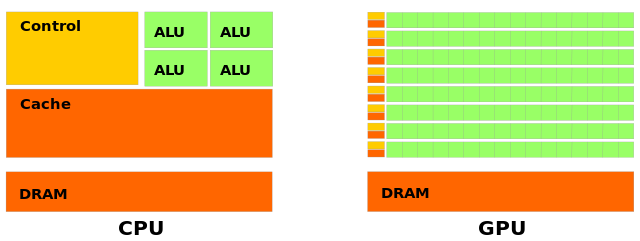
<p>Figure 1.1. Simplified CPU architecture (left) and GPU architecture (right). Arithmetic happens in the ALU (arithmetic logic unit), DRAM data, cache holds even data that can be accessed even faster, but generally has less capacity. The control unit executes instructions. Credit: <a href="https://commons.wikimedia.org/wiki/File:Cpu-gpu.svg">Wikipedia</a>.</p>
</center>

### Getting Started

We will start by setting up our environment: a Numba version higher than 0.55 and a supported GPU.

In [ ]:
!pip install --upgrade numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 20.3 MB/s 
     |████████████████████████████████| 34.6 MB 116 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
import numpy as np

import numba
from numba import cuda

print(np.__version__)
print(numba.__version__)

1.21.6
0.56.0


In [ ]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-5faf6602-f791-0c92-8b17-4150136d9306
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

The main workhorse of Numba CUDA is the `cuda.jit` decorator. It is used to define functions which will run in the GPU. 

We'll start by defining a simple function, which takes two numbers and stores them on the first element of the third argument. Our first lesson is that kernels (GPU functions that launch threads) cannot return values. We get around that by passing inputs *and* outputs. This is a common pattern in C, but not very common in Python.

In [ ]:
# Example 1.1: Add scalars
@cuda.jit
def add_scalars(a, b, c):
    c[0] = a + b

In [ ]:
dev_c = cuda.device_array((1,), np.float32)

add_scalars[1, 1](2.0, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


2.0 + 7.0 = 9.0


As you may have noticed, before we call the kernel, we need to allocate an array on the device. In addition, if we want to display the returned value, we need to copy it back to the CPU. You might be asking yourself why we chose to allocate a `float32` (single-precision float). This is because, while supported in most modern GPUs, double precision arithmetic can take 4x or longer than single precision arithmetic. So it's better to get used to using `np.float32` and `np.complex64` instead of `float`/`np.float64` and `complex`/`np.complex128`. 

Whereas the kernel definition looks similar to a CPU function, the kernel call is a little different. In particular, it has square brackets before the arguments:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>add_scalars<font color="crimson">[1, 1]</font>(2.0, 7.0, dev_c)</code>

These square brackets refer to the number of *blocks* in a grid, and the number of *threads* in a block, respectively. Let's talk a little bit more about what these mean as we learn to parallelize with CUDA.

### Parallelization with CUDA


#### The anatomy of a CUDA grid
When a kernel is launched it has a *grid* associated with it. A grid is composed of *blocks*; a block is composed of *threads*. Figure 2 shows a one dimensional CUDA grid. The grid in the figure has 4 blocks. The number of blocks in a grid is held in a special variable which can be accessed inside the kernel called `gridDim.x`. The `.x` is refers to the first dimensional of the grid (the only one in this case). Two dimensional grids also have `.y` and three dimensional grids, `.z` variables. As of 2022, there are no 4-dimensional grids or higher. Also inside the kernel, you can find out which block is being executed through the use of `blockIdx.x`, which in this case will run from 0 to 3. 

Each block has a certain number of threads, held in the variable `blockDim.x`. Thread indices are held in the variable `threadIdx.x`, which in this example will run from 0 to 7.

Importantly, threads in different blocks are scheduled to run differently, have access to different memory regions, and differ in some other ways (see [*CUDA Refresher: The CUDA Programming Model*](https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/) for a brief discussion). For now, we will skip these details.

<center>
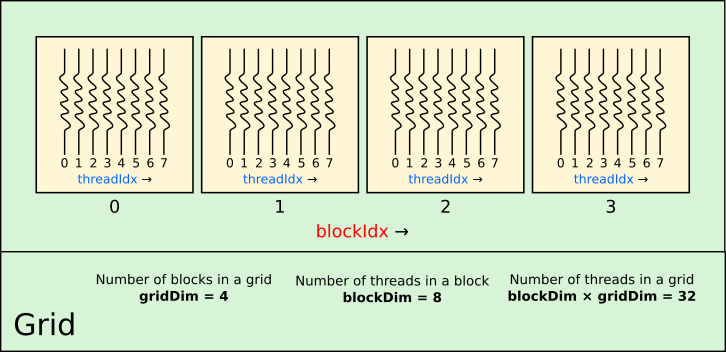
<p>Figure 1.2. A one dimensional CUDA grid. Image by author.</p>
</center>

When we launched the kernel in our first example with parameters `[1, 1]`, we told CUDA to run one block with one thread. Passing several blocks with several threads, will run the kernel many times. Manipulating <code><font color="blue">threadIdx.x</font></code> and <code><font color="crimson">blockIdx.x</font></code> will allow us to uniquely identify each thread.

Instead of summing two numbers, let's try to sum two arrays. Suppose the arrays each have 20 elements. Like in the figure above, we can launch a kernel with 8 threads per block. If we want each thread to handle only one array element, we will then need at least 4 blocks. Launching 4 blocks, 8 threads each, our grid will then launch 32 threads.

Now we need to figure out how to map the thread indices to the array indices. <code><font color="blue">threadIdx.x</font></code> runs from 0 to 7, so on their own they are not able to index our array. In addition, different blocks have the same <code><font color="blue">threadIdx.x</font></code>. On the other hand, they have different <code><font color="crimson">blockIdx.x</font></code>. To obtain a unique index for each thread, we can combine these variables:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<code>
i = <font color="blue">threadIdx.x</font> + <font color="green">blockDim.x</font> * <font color="crimson">blockIdx.x</font>
</code>

For the first block, `blockIdx.x = 0` and `i` will run from 0 to 7. For the second block, `blockIdx.x = 1`. Since `blockDim.x = 8`, `i` will run from 8 to 15. Similarly, for `blockIdx.x = 2`, `i` will run from 16 to 23. In the fourth and final block, `i` will run fro
m 24 to 31. See Table 1 below.

| `i`           | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   | 11   | 12   | 13   | 14   | 15   | 16   | ...   | 31   |
| ----------- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
| `threadIdx.x` | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 0    | ...    | 7    |
| `blockIdx.x`  | 0    | 0    | 0    | 0    | 0    | 0    | 0    | 0    | 1    | 1    | 1    | 1    | 1    | 1    | 1    | 1    | 2    | ...    | 3    |

<center><p>Table 1.1. Linear indexing with thread and block variables.</p></center>

We solved one problem: how to map each thread to each element in the array... but now we have an issue where some threads would overflow the array, since the array has 20 elements and `i` goes up to 32-1. The solution is simple: for those threads, don't do anything!

Let's see the code.

In [ ]:
# Example 1.2: Add arrays
@cuda.jit
def add_array(a, b, c):
    i = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if i < a.size:
        c[i] = a[i] + b[i]

In [ ]:
N = 20
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)
dev_c = cuda.device_array_like(a)

add_array[4, 8](a, b, dev_c)

c = dev_c.copy_to_host()
print(c)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In newer versions of Numba, we get a warning noting that we called the kernel with host arrays. Ideally, we want to avoid moving data around from host to device, as this is very slow. We should be calling the kernel with device arrays in all arguments. We can do that by moving the array from host to device beforehand:

In [ ]:
dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)

Moreover, the calculation of unique indices per thread can get old quickly. Thankfully Numba provides the very simple wrapper `cuda.grid` which is called with the grid dimension as the only argument. The new kernel will look like this:

In [ ]:
# Example 1.3: Add arrays with cuda.grid
@cuda.jit
def add_array(a, b, c):
    i = cuda.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]

We may now call the new kernel:

In [ ]:
add_array[4, 8](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
print(c)

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38.]


What happens when we change the size of the array? One easy way out is to simply change the grid parameters (number of blocks and threads per block) in order to launch at least as many threads as there are elements in the array.

There is some science and some art to setting these parameters. For the "science", we will say that (a) they should be a multiple of two, typically between 32 and 1024, and (b) they should be chosen so as to maximize *occupancy* (how many threads are active at the same time). Nvidia provides a [spreadsheet](https://docs.nvidia.com/cuda/cuda-occupancy-calculator/index.html) that can help calculating these. For the "art", nothing can predict the behavior of your kernels, so if you truly want to optimize these parameters, you need to profile your code with typical inputs. In practice, a "reasonable" number of threads for modern GPUs is 256.

In [ ]:
N = 1_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)
dev_c = cuda.device_array_like(a)

threads_per_block = 256
blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block
# Note that
#     blocks_per_grid == ceil(N / threads_per_block)
# ensures that blocks_per_grid * threads_per_block >= N

add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

Before we move on from summing vectors, we need to talk about hardware limits. GPUs cannot run an arbitrary number of threads and blocks. Typically each block cannot have more than 1024 threads, and a grid cannot have more than 2<sup>16</sup> - 1 = 65535 blocks. This is not to say that you can launch 1024 × 65535 threads... there are limits to the number of threads that can be launched based on how much memory their registers occupy, among other considerations. Moreover, one must be wary of trying to process large arrays which do not fit in the GPU RAM all at once. In these cases, one may benefit from processing the arrays piecewise, either using a single GPU or multiple GPUs.

---
$\color{Goldenrod}{\textbf{INFO}}$

In Python, hardware limits can be obtained through Nvidia's `cuda-python` library through [the function `cuDeviceGetAttribute` in their documentation](https://nvidia.github.io/cuda-python/module/cuda.html#cuda.cuda.cuDeviceGetAttribute). See the Appendix at the end of this section for an example.

---

#### Grid-stride loops

In cases where the number of blocks per grid exceeds the hardware limit but the array fits in memory, instead of using one thread per array element, we can use one thread to process several elements. We will do so by using a technique called *grid-stride loops*. Besides overcoming hardware limitations, grid-stride loop kernels benefit from reusing threads, by minimizing thread creation/destruction overhead. Mark Harris' blog post [*CUDA Pro Tip: Write Flexible Kernels with Grid-Stride Loops*](https://developer.nvidia.com/blog/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/) goes into detail about some of the benefits of grid-strided loops.

The idea behind this technique is to add a loop inside of the CUDA kernel to process multiple input elements. The stride of this loop, as the name implies, is equal to the number of threads in a grid. This way, if the total number of threads in the grid  (`threads_per_grid = blockDim.x * gridDim.x`) is smaller than the number of elements of the array, as soon as the kernel is done processing the index `cuda.grid(1)` it will process the index `cuda.grid(1) + threads_per_grid` and so on until all array elements have been processed. Without further ado, let's look at the code.

In [ ]:
# Example 1.4: Add arrays with grid striding
@cuda.jit
def add_array_gs(a, b, c):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

In [ ]:
threads_per_block = 256
blocks_per_grid_gs = 32 * 80  # Use 32 * multiple of streaming multiprocessors
# 32 * 80 * 256 < 1_000_000 so one thread will process more than one array element

add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

This code is very similar to the above, with the different that we are *starting* at `cuda.grid(1)`, but executing more samples, one every `threads_per_grid` until we hit the end of the array.

Now, which one of these kernels is faster?

### Timing CUDA Kernels

GPU programming is all about speed. Therefore it is important to measure code execution accurately.

CUDA kernels are device functions that are *launched* by the host (CPU), but of course they are executed on the GPU. The GPU and the CPU don't communicate unless we tell them to. So when the GPU kernel is launched, the CPU will simply continue running instructions, be they launching more kernels or executing other CPU functions. If we place a `time.time()` call before and after kernel launch, we will be timing only how long it takes for the kernel to *launch*, not to *run*.

One function we can use to ensure that the GPU has "caught up" is the `cuda.synchronize()`. Calling this function will stop the host from executing any other code until the GPU finishes execution of every kernel that has been launched in it.

To time a kernel execution, we can then simply time how long it takes for the kernel to run and then synchronize. There are two caveats to this. First, we need to use `time.perf_counter()` or `time.perf_counter_ns()`and not `time.time()`. `time.time()` does not count the time that the host is sleeping waiting for the GPU to finish execution. The second caveat is that timing code from the host is not ideal as there are overheads related to this. Later, we will explain how one can use CUDA *events* to time kernels from the device. Mark Harris has another excellent blog post about this topic entitled [*How to Implement Performance Metrics in CUDA C/C++*](https://developer.nvidia.com/blog/how-implement-performance-metrics-cuda-cc/).

When using Numba, we have one detail we must pay attention to. Numba is a Just-In-Time compiler, meaning that the functions are only compiled when they are called. Therefore timing the first call of the function *will also time the compilation step* which is in general much slower. We must remember to always compile the code first by launching the kernel and then synchronizing it to ensure that nothing is left to run in the GPU. This ensures that the next kernel runs immediately without compilation. Also note that the `dtype` of the array should be the same, as Numba compiles a unique function for each combination of argument `dtypes`.

In [ ]:
from time import perf_counter_ns

In [ ]:
# Compile and then clear GPU from tasks
add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)
cuda.synchronize()

timing = np.empty(101)
for i in range(timing.size):
    tic = perf_counter_ns()
    add_array[blocks_per_grid, threads_per_block](dev_a, dev_b, dev_c)
    cuda.synchronize()
    toc = perf_counter_ns()
    timing[i] = toc - tic
timing *= 1e-3  # convert to μs

print(f"Elapsed time: {timing.mean():.0f} ± {timing.std():.0f} μs")

Elapsed time: 226 ± 200 μs


In [ ]:
# Compile and then clear GPU from tasks
add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
cuda.synchronize()

timing_gs = np.empty(101)
for i in range(timing_gs.size):
    tic = perf_counter_ns()
    add_array_gs[blocks_per_grid_gs, threads_per_block](dev_a, dev_b, dev_c)
    cuda.synchronize()
    toc = perf_counter_ns()
    timing_gs[i] = toc - tic
timing_gs *= 1e-3  # convert to μs

print(f"Elapsed time: {timing_gs.mean():.0f} ± {timing_gs.std():.0f} μs")

Elapsed time: 209 ± 194 μs


For simple kernels, we can also measure the throughout of the algorithm, which equals the number of floating point operations per second. It is usually measured in GFLOP/s (giga-FLOP per second). Our adding operation contains only one FLOP: addition. As such, the throughput is given by:

In [ ]:
#              G * FLOP       / timing in s
gflops    = 1e-9 * dev_a.size * 1e6 / timing.mean()
gflops_gs = 1e-9 * dev_a.size * 1e6 / timing_gs.mean()

In [ ]:
print(f"GFLOP/s (algo 1): {gflops:.2f}")
print(f"GFLOP/s (algo 2): {gflops_gs:.2f}")

GFLOP/s (algo 1): 4.42
GFLOP/s (algo 2): 4.80


### A 2D Example

To end this tutorial, let's craft a 2D kernel to apply [logarithmic correction](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.adjust_log) to an image.

Given an image $I(x, y)$ with values between 0 and 1, the log-corrected image is given by

$$I_c(x, y) = \gamma \log_2 (1 + I(x, y))$$

First let's grab some data!

In [ ]:
from skimage import data

moon = data.moon().astype(np.float32) / 255.

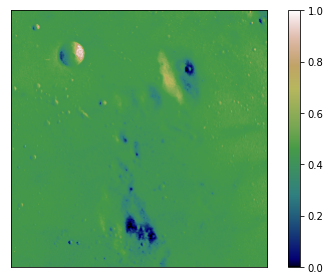

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(moon, cmap="gist_earth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

As you can see, the data is really saturated at the lower end. There are almost no values above 0.6.

Let's write the kernel.

In [ ]:
import math

# Example 1.5: 2D kernel
@cuda.jit
def adjust_log(inp, gain, out):
    ix, iy = cuda.grid(2) # The first index is the fastest dimension
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #  threads per grid dimension
    
    n0, n1 = inp.shape # The last index is the fastest dimension
    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1 + inp[i0, i1])

Let us make note of the two `for` loops. Notice that that the first `for` loop starts at `iy` and the second, innermost loop starts at `ix`. We could have easily chosen `i0` to start at `ix` and `i1` to start at `iy` instead, which would even feel more natural. So why did we choose this order? It turns out that the memory access pattern for the first choice is more efficient. Since the first grid index is the fastest one, we want to make it match our fastest dimension: the last one.

If you don't want to take my word for it (and you shouldn't!) you have now learned how to time kernel executions, and you can try out the two versions. For small arrays such as the one using here, the difference is negligible, but for larger arrays (say 10,000 by 10,000), I have measured a speedup of about 10%. Not super impressive, but if I could give you a 10% improvement with a single swapping of variables, who wouldn't take it?

In [ ]:
threads_per_block_2d = (16, 16)  #  256 threads total
blocks_per_grid_2d = (64, 64)

In [ ]:
moon_gpu = cuda.to_device(moon)
moon_corr_gpu = cuda.device_array_like(moon_gpu)

adjust_log[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 1.0, moon_corr_gpu)
moon_corr = moon_corr_gpu.copy_to_host()

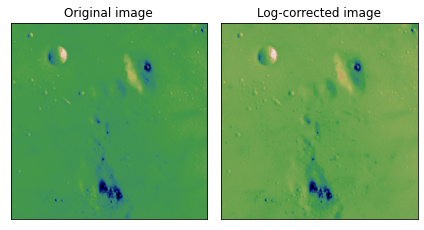

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(moon_corr, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()

And that's it! We can now see more details in the corrected image.

As an exercise, try timing different launches with different grids to find the optimal grid size for your machine.

### Appendix: Using Nvidia's cuda-python to probe device attributes

For fine-grained control over the exact attributes of your GPU, you can rely on the lower-level, official CUDA Python package provided by Nvidia.

In [ ]:
!pip install --upgrade cuda-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 22.0 MB/s 


In [ ]:
from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit

In [ ]:
# Initialize CUDA Driver API
(err,) = cuInit(0)

In [ ]:
# Get attributes
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

In [ ]:
print(f"Device Name: {DEVICE_NAME}")
print(f"Maximum number of multiprocessors: {SMs}")
print(f"Maximum number of threads per block: {MAX_THREADS_PER_BLOCK:10}")
print(f"Maximum number of blocks per grid:   {MAX_BLOCK_DIM_X:10}")
print(f"Maximum number of threads per grid:  {MAX_GRID_DIM_X:10}")

Device Name: Tesla T4                                                                
Maximum number of multiprocessors: 40
Maximum number of threads per block:       1024
Maximum number of blocks per grid:         1024
Maximum number of threads per grid:  2147483647
